**Copy of CISC-873-DM-W23-A4
Airbnb price category prediction**

Galena Wagdy Zareef - 20399124 -Data Mining competition 4

One of the biggest problems when people prepare to post a new listing on airbnb is, how much should one ask for? Of course the most intuitive way is to check how other similar postings price their apartment/house. So in this assignment, we are going to predict the listing price based on the listing characteristics 🔥🔥, in this way to optimize user experience and lower the bar to be a new host😍 !

Predicting the actual price could be simple (well you can just go search online 👍), so we cut the pricing into three different bins for classification 😂. For each listing, we recommend a pricing range to the new host rather than a fix price (how nice is that!). So we define three categories: beginner, plus, premium based on the created listing. Respectively we use 0, 1, 2 to denote these three categories.

The dataset contains listings of different areas in Montreal during 2019. It comes with rich information for each listing, including a link to the thumbnails etc. As discussed in the last lecture, we will follow a multi-objective (multi-task) multi-modality solution.

training data containes 4 columns
one column have images link.

In [4]:
# importing dependencies for data and image manipulation
import os
import pandas as pd
from tqdm.notebook import tqdm
from PIL import Image
import pandas as pd
import numpy as np

xy_train_df = pd.read_csv('/kaggle/input/copy-of-cisc-873-dm-w23-a4/a4/train_xy.csv') # reading our training features and labels into a df
x_test_df = pd.read_csv('/kaggle/input/copy-of-cisc-873-dm-w23-a4/a4/test_x.csv') # reading test features into a df

In [5]:
# preprocess image data

def load_image(file):
    try:
        image = Image.open(
            file
        ).convert('LA').resize((64, 64)) # read each image as a greyscale image size (64x64x2)
        arr = np.array(image) # convert each image to an array
    except:
        arr = np.zeros((64, 64, 2)) # if an image can't be loaded, return an array of zeros (same size: 64x64x2)
    return arr


# loading images:
x_image = np.array([load_image(i) for i in tqdm(xy_train_df.image)]) # load each image from the provided directory using the function created above

# loading summary: (force convert some of the non-string cell to string)
x_text = xy_train_df.summary.astype('str') # also load the summary text accompanying each image, force convert to strings in cases where the encoding is weird, etc.


  0%|          | 0/7627 [00:00<?, ?it/s]

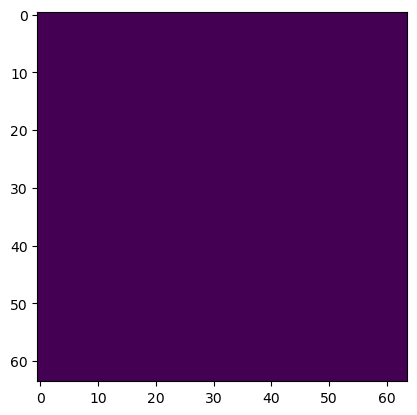

In [6]:
# check image loading
import matplotlib.pyplot as plt
plt.imshow(x_image[0, :, :, 0]) # displaying a sample image, note that similar to the last assignment, pyplot uses a default cmap, and these images are actually greyscale

In [7]:
from sklearn.model_selection import train_test_split # used to create a hold-out set for validation

# labels:
y_price = xy_train_df.price # price category/label, either 0, 1, or 2 corresponding to beginner, plus, or premium respectively
y_type = xy_train_df.type.astype('category').cat.codes # rental type label, categorically encode 24 available property types (i.e. hotel, apartment, villa, boat, etc.)

len_price = len(y_price.unique()) # number of unique labels for price
len_type = len(y_type.unique()) # number of unique labels for rental type
print('unique values for price category', len_price, y_price.unique()) # print them so we can see the unique values for our labels
print('unique values for type category', len_type, y_type.unique())

# splitting:

# the following creates training and validation splits for our image and text feature spaces
# along with our two label sets, price and rental type
x_tr_image, x_vl_image, x_tr_text, x_vl_text, y_tr_price, y_vl_price, y_tr_type, y_vl_type = train_test_split(
    x_image, 
    x_text,
    y_price,
    y_type,
    test_size=0.2) # our validation splits are a hold-out set containing 20% of the training set

print(np.shape(x_tr_image)) # 6101 training images of size (64x64x2)
print(np.shape(x_vl_image)) # 1526 validation images of size (64x64x2)
print(np.shape(y_tr_price)) # 6101 price labels for training
print(np.shape(y_vl_price)) # 1526 price labels for validation
print(np.shape(y_tr_type)) # 6101 type labels for training
print(np.shape(y_vl_type)) # 1526 type labels for validation

# note also that there are also 6101 text samples for training and 1526 text samples for validation

unique values for price category 3 [1 0 2]
unique values for type category 24 [ 1 17 22 10 18 20  5  2  8  4 23 13 15 16 14 11 19  0 21  3  6 12  7  9]
(6101, 64, 64, 2)
(1526, 64, 64, 2)
(6101,)
(1526,)
(6101,)
(1526,)


In [8]:
# preprocess text data

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pprint import pprint

vocab_size = 40000 # enforce a threshold on the number of unique words that are tokenized
max_len = 100 # maximum sequence length of a text string, anything longer will be truncated to 100 words


# build vocabulary from training set
tokenizer = Tokenizer(num_words=vocab_size) # initialize tokenizer with a vocabulary size of 40000
tokenizer.fit_on_texts(x_tr_text) # update the vocabulary by fitting on the corpus of text contained in rental text descriptions, keeping only the most common 40000 words


def _preprocess(list_of_text):
    return pad_sequences(
        tokenizer.texts_to_sequences(list_of_text), # transforms each list entry to a sequence of integers based on the vocabulary created from fitting the tokenizer on the training set above
        maxlen=max_len, # enforce max sequence length of 100
        padding='post', # if a sequence length is less than 100, add padding at the end to make it 100 words long
    )
    

# padding is done inside: 
x_tr_text_id = _preprocess(x_tr_text) # preprocess and tokenize list of training sequences
x_vl_text_id = _preprocess(x_vl_text) # preprocess and tokenize list of validation sequences

# As we can see, our 6101 training and 1526 validation text samples have been tokenized to match the maximum sequence length of 100
print(x_tr_text_id.shape)
print(x_vl_text_id.shape)

(6101, 100)
(1526, 100)


In [9]:
# printing the first 5 text sequences based on their tokenized form, essentially
# a lookup to show that the input sequences have been tokenized properly 
pprint(tokenizer.sequences_to_texts(x_tr_text_id[:5]))

['you are looking for a temporary place in montreal that will allow you to '
 'explore the city its monuments its diversity of activities and festivals '
 'while living like a local this apartment is made for you',
 'location location location my apartment is right in the heart of downtown '
 'montreal surrounded by restaurants bars shopping malls pubs and clubs there '
 'is always something to do concordia is located right across the street and '
 'mcgill is minutes away walking distance old montreal is also about a 15 min '
 'walk 2 5 km the apartment building is very safe with cameras and a security '
 'keypad at the front of the building to prevent random pedestrians from '
 'coming through',
 'idéalement située sur une des plus belles rues du plateau mont royal à 2 pas '
 'du métro sherbrooke à 2 coins de rues de st denis avec ses boutiques et ses '
 'cafés à un coin de rue du parc lafontaine proche du centre ville du quartier '
 'des spectacles cinémas théâtres village et vieux m

In [10]:
# number of unique words contained in the vocabulary
print('total words in the dictionary:', tokenizer.num_words)

total words in the dictionary: 40000


In [11]:
# time to define a model, so we need more dependencies
from __future__ import absolute_import, division, print_function, unicode_literals # not sure why we need these
import collections
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
from tensorflow.keras.optimizers import Adam

in_text = keras.Input(batch_shape=(None, max_len)) # input shape for batches of text sequences (100 words long)
in_image = keras.Input(batch_shape=(None, 64, 64, 2)) # input shape for batches of images (size 64x64x2)

# text part
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text) # get our word embeddings
averaged = tf.reduce_mean(embedded, axis=1) # compute the mean of the embeddings to reduce the rank of the embedding


# image part
cov = Conv2D(32, (16, 16))(in_image) # convolutional layer with 32 filters, and a 16x16 mask, no padding
pl = MaxPool2D((16, 16))(cov) # max pooling with a 16x16 mask, reducing the size to 3x3x32
flattened = Flatten()(pl) # flatten the shape to (288,)


# fusion:
fused = tf.concat([averaged, flattened], axis=-1) # concatenate text features with images

# multi-objectives (each is a multi-class classification)
p_price = Dense(len_price, activation='softmax', name='price')(fused) # predict price label 0, 1, or 2
p_type = Dense(len_type, activation='softmax', name='type')(fused) # predict rental category label [0-23]

# model definition
model = keras.Model(
    inputs={
        'summary': in_text, # text inputs
        'image': in_image # image inputs
    },
    outputs={
        'price': p_price, # label 1: price category (0, 1, or 2)
        'type': p_type, # label 2: type category [0-23]
    },
)

# compile model
model.compile(
    optimizer=Adam(), # using Adam for optimization
    # measuring sparse categorical cross-entropy loss for both price and type labels
    # sparse categorical cross-entropy is used since our labels are integers
    loss={
        'price': 'sparse_categorical_crossentropy',
        'type': 'sparse_categorical_crossentropy',
    },
    # equally weight the loss w.r.t. both labels
    loss_weights={
        'price': 0.5,
        'type': 0.5,       
    },
    # evaluation metric for this task is accuracy, so we measure sparse categorical accuracy for both targets
    # again, our labels are categorical integers, so we use sparse categorical accuracy
    metrics={
        'price': ['SparseCategoricalAccuracy'],
        'type': ['SparseCategoricalAccuracy'],
    },
)


model.summary() # print the structure of the model defined above 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 49, 49, 32)   16416       ['input_2[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 100, 100)     4000000     ['input_1[0][0]']                
                                                                                              

In [12]:
# fit our model on our training data
history = model.fit(
    # our inputs: tokenized text sequences and resized image samples
    x={
        'summary': x_tr_text_id,
        'image': x_tr_image
    },
    # our outputs: price and rental type categories
    y={
        'price': y_tr_price,
        'type': y_tr_type,
    },
    epochs=20, # train for 20 epochs (iterations over all training data)
    batch_size=16, # batch size of 16 (samples processed before updating gradients)
    # our validation splits for our two input sets and our two target attributes
    validation_data=(
        {
            'summary': x_vl_text_id,
            'image': x_vl_image
         }, 
        {
            'price': y_vl_price,
            'type': y_vl_type,
        }),
    validation_split=0.2, # validate on a hold-out set of 20%, even though splits were already created above???? Pretty sure this is redundant.
    # use early stopping, monitor the validation price loss and if it does not improve for 5 consecutive epochs, training will stop
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5, )
    ],
    verbose=1 # one line per epoch displaying performance metrics
)

Epoch 1/20
382/382 [==============================] - 47s 120ms/step - loss: 1.0391 - price_loss: 0.8495 - type_loss: 1.2287 - price_sparse_categorical_accuracy: 0.6184 - type_sparse_categorical_accuracy: 0.7522 - val_loss: 0.9020 - val_price_loss: 0.8257 - val_type_loss: 0.9783 - val_price_sparse_categorical_accuracy: 0.6075 - val_type_sparse_categorical_accuracy: 0.7588
Epoch 2/20
382/382 [==============================] - 46s 120ms/step - loss: 0.8864 - price_loss: 0.7941 - type_loss: 0.9787 - price_sparse_categorical_accuracy: 0.6358 - type_sparse_categorical_accuracy: 0.7551 - val_loss: 0.8711 - val_price_loss: 0.7899 - val_type_loss: 0.9522 - val_price_sparse_categorical_accuracy: 0.6291 - val_type_sparse_categorical_accuracy: 0.7588
Epoch 3/20
382/382 [==============================] - 46s 120ms/step - loss: 0.8342 - price_loss: 0.7370 - type_loss: 0.9315 - price_sparse_categorical_accuracy: 0.6722 - type_sparse_categorical_accuracy: 0.7551 - val_loss: 0.8404 - val_price_loss: 0

In [13]:
x_test_summary = _preprocess(x_test_df.summary.astype(str)) # create sequences for the text summaries in the test set
x_test_image = np.array([load_image(i) for i in tqdm(x_test_df.image)]) # load and resize the images from the test set


  0%|          | 0/7360 [00:00<?, ?it/s]

In [14]:
# generate predictions on the test set using the tokenized summaries and re-sized images
y_predict = model.predict(
    {
        'summary': x_test_summary,
        'image': x_test_image
    }
)

price_predicted = y_predict['price'] # this is the target attribute we care about for this task
print(price_predicted) # probability the sample belongs to each of the categories
price_category_predicted = np.argmax(price_predicted, axis=1) # pick the highest value, and assign it as the predicted class
print(price_category_predicted) # print the categorical predictions, which are in [0,1,2]

# create the submission dataframe/csv for submission
pd.DataFrame(
    {'id': x_test_df.id,
     'price': price_category_predicted}).to_csv('sample_submission.csv', index=False)

230/230 [==============================] - 8s 36ms/step
[[0.7265812  0.22634968 0.04706906]
 [0.9837603  0.01293819 0.00330147]
 [0.9094726  0.06200176 0.02852566]
 ...
 [0.7568126  0.21376052 0.02942695]
 [0.982217   0.01225147 0.00553153]
 [0.84532636 0.12705895 0.02761473]]
[0 0 0 ... 0 0 0]


In [15]:
# helper functions (adopted from template code, as usual)

# method used to plot history after training to explore model behaviour
def results_viz(history):
    

  # generate a figure containing 3 plots displayed horizontally
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
    fig.suptitle('Model Results')
  
  # first we display the training price accuracy vs. the validation price accuracy
    ax1.plot(history.history['price_sparse_categorical_accuracy'])
    ax1.plot(history.history['val_price_sparse_categorical_accuracy'])
    ax1.set_title('price accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['train_price', 'validation_price'], loc='upper left')

  # same with the other specified accuracy metric, type accuracy
    ax2.plot(history.history['type_sparse_categorical_accuracy'])
    ax2.plot(history.history['val_type_sparse_categorical_accuracy'])
    ax2.set_title('type accuracy')
    ax2.set_ylabel('accuracy')
    ax2.set_xlabel('epoch')
    ax2.legend(['train_type', 'validation_type'], loc='upper left')

  # on the last axis, we plot the training loss against the validation loss (w.r.t. price and type combined)
    ax3.plot(history.history['loss'])
  ax3.plot(history.history['val_loss'])
  ax3.set_title('model loss')
  ax3.set_ylabel('loss')
  ax3.set_xlabel('epoch')
  ax3.legend(['train', 'validation'], loc='upper left')

  plt.show() # display the figure

# method used to generate predictions on test set, adopted from code in template
def test(model, filename):
      y_predict = model.predict(
      {
          'summary': x_test_summary,
          'image': x_test_image
      }
  )
  price_predicted = y_predict['price'] 
      price_category_predicted = np.argmax(price_predicted, axis=1) 

  # create the submission dataframe/csv for submission
    pd.DataFrame(
      {'id': x_test_df.id,
      'price': price_category_predicted}).to_csv(f'{filename}.csv', index=False)

def compile(model, lr=0.001):
  # compile model
  model.compile(
      optimizer=Adam(learning_rate=lr), # using Adam for optimization
      # measuring sparse categorical cross-entropy loss for both price and type labels
      # sparse categorical cross-entropy is used since our labels are integers
      loss={
          'price': 'sparse_categorical_crossentropy',
          'type': 'sparse_categorical_crossentropy',
      },
      # equally weight the loss w.r.t. both labels
      loss_weights={
          'price': 0.5,
          'type': 0.5,       
      },
      # evaluation metric for this task is accuracy, so we measure sparse categorical accuracy for both targets
      # again, our labels are categorical integers, so we use sparse categorical accuracy
      metrics={
          'price': ['SparseCategoricalAccuracy'],
          'type': ['SparseCategoricalAccuracy'],
      },
  )

def train(model, cbs, epochs=20, batch=16, val=0.2):
  # fit our model on our training data
  history = model.fit(
      # our inputs: tokenized text sequences and resized image samples
      x={
          'summary': x_tr_text_id,
          'image': x_tr_image
      },
      # our outputs: price and rental type categories
      y={
          'price': y_tr_price,
          'type': y_tr_type,
      },
      epochs=epochs, # variable, number of iterations over all training data
      batch_size=batch, # variable batch size, samples processed before updating gradients
      # our validation splits for our two input sets and our two target attributes
      validation_data=(
          {
              'summary': x_vl_text_id,
              'image': x_vl_image
          }, 
          {
              'price': y_vl_price,
              'type': y_vl_type,
          }),
      validation_split=val, # validate on a hold-out set of 20%, even though splits were already created above???? This is redundant.
      # use early stopping, monitor the validation price loss and if it does not improve for 5 consecutive epochs, training will stop
      callbacks=cbs,
      verbose=1 # one line per epoch displaying performance metrics
  )
return history

In [16]:
# let's try training longer to see if a trend presents itself over time
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=10, )]

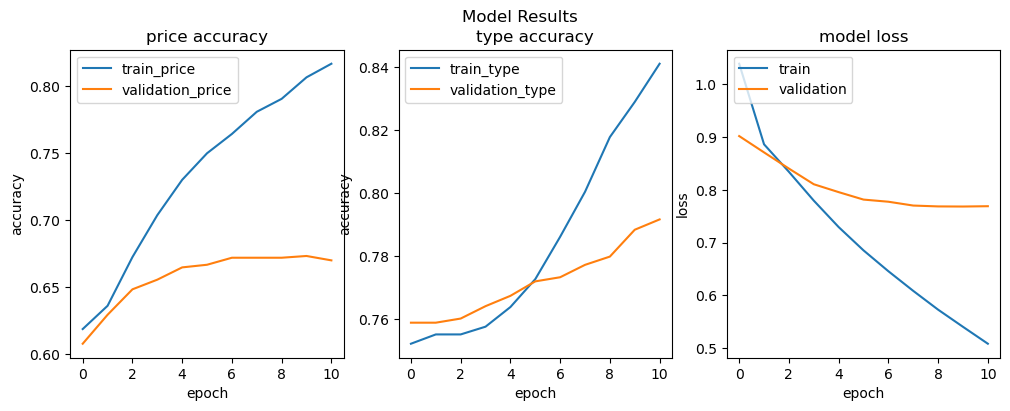

In [17]:
# let's look at the accuracy and loss curves from the template
results_viz(history)

In [18]:
from tensorflow.keras.layers import LSTM # bringing an LSTM layer into the fold

# copied the model from the template and modifying it here
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2)) # input shape for batches of images (size 64x64x2)

# text part
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text) # get our word embeddings

# only part I'm changing is adding an LSTM layer on top of the embedding layer
# averaged = tf.reduce_mean(embedded, axis=1) # compute the mean of the embeddings to reduce the rank of the embedding
lstm = LSTM(50)(embedded)

# image part
cov = Conv2D(32, (16, 16))(in_image) # convolutional layer with 32 filters, and a 16x16 mask, no padding
pl = MaxPool2D((16, 16))(cov) # max pooling with a 16x16 mask, reducing the size to 3x3x32
flattened = Flatten()(pl) # flatten the shape to (288,)


# fusion:
fused = tf.concat([lstm, flattened], axis=-1) # concatenate text features with images

# multi-objectives (each is a multi-class classification)
p_price = Dense(len_price, activation='softmax', name='price')(fused) # predict price label 0, 1, or 2
p_type = Dense(len_type, activation='softmax', name='type')(fused) # predict rental category label [0-23]

# model definition
lstm_model = keras.Model(
    inputs={
        'summary': in_text, # text inputs
        'image': in_image # image inputs
    },
    outputs={
        'price': p_price, # label 1: price category (0, 1, or 2)
        'type': p_type, # label 2: type category [0-23]
    },
)

compile(lstm_model) # compiles the model with the helper to improve readability
lstm_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 49, 49, 32)   16416       ['input_4[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 100, 100)     4000000     ['input_3[0][0]']                
                                                                                            

In [19]:
history = train(lstm_model, callbacks) # use train helper to improve readability

Epoch 1/20
382/382 [==============================] - 61s 150ms/step - loss: 0.9991 - price_loss: 0.8488 - type_loss: 1.1495 - price_sparse_categorical_accuracy: 0.6224 - type_sparse_categorical_accuracy: 0.7495 - val_loss: 0.9312 - val_price_loss: 0.8513 - val_type_loss: 1.0112 - val_price_sparse_categorical_accuracy: 0.6075 - val_type_sparse_categorical_accuracy: 0.7588
Epoch 2/20
382/382 [==============================] - 57s 149ms/step - loss: 0.9278 - price_loss: 0.8392 - type_loss: 1.0164 - price_sparse_categorical_accuracy: 0.6245 - type_sparse_categorical_accuracy: 0.7551 - val_loss: 0.9243 - val_price_loss: 0.8458 - val_type_loss: 1.0027 - val_price_sparse_categorical_accuracy: 0.6075 - val_type_sparse_categorical_accuracy: 0.7588
Epoch 3/20
382/382 [==============================] - 57s 149ms/step - loss: 0.9263 - price_loss: 0.8375 - type_loss: 1.0151 - price_sparse_categorical_accuracy: 0.6245 - type_sparse_categorical_accuracy: 0.7551 - val_loss: 0.9269 - val_price_loss: 0

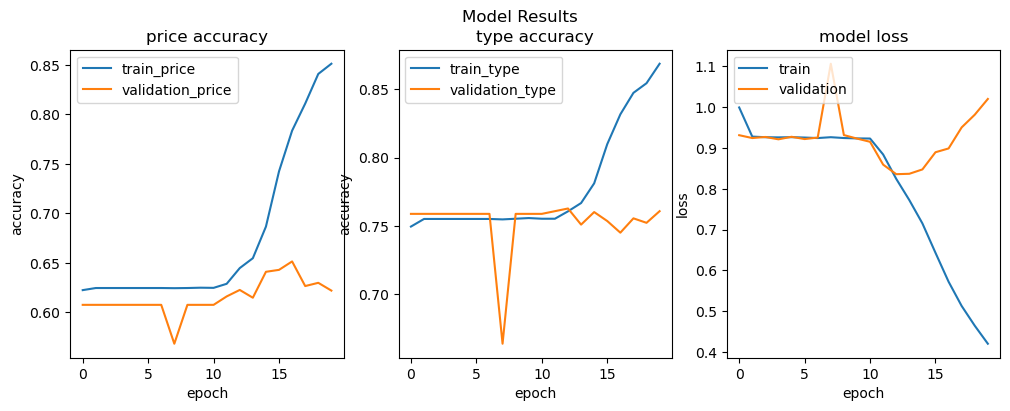

In [20]:
# looking at the curves below, we see a similar behaviour to that in the template. 
# The model does not appear to be learning much, see the training curve.
results_viz(history)

In [21]:
# let's generate our predictions and submit to Kaggle 😋
test(lstm_model,'trial1')

230/230 [==============================] - 10s 43ms/step


In [22]:
from tensorflow.keras.layers import GRU

in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2)) # input shape for batches of images (size 64x64x2)

# text part
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text) # get our word embeddings
# averaged = tf.reduce_mean(embedded, axis=1) # compute the mean of the embeddings to reduce the rank of the embedding
lstm = GRU(20)(embedded) # fewer hidden units might improve training time?

# image part
cov = Conv2D(32, (16, 16))(in_image) # convolutional layer with 32 filters, and a 16x16 mask, no padding
pl = MaxPool2D((16, 16))(cov) # max pooling with a 16x16 mask, reducing the size to 3x3x32
flattened = Flatten()(pl) # flatten the shape


# fusion:
fused = tf.concat([lstm, flattened], axis=-1) # concatenate text features with images

# multi-objectives (each is a multi-class classification)
p_price = Dense(len_price, activation='softmax', name='price')(fused) # predict price label 0, 1, or 2
p_type = Dense(len_type, activation='softmax', name='type')(fused) # predict rental category label [0-23]

# model definition
gru_model = keras.Model(
    inputs={
        'summary': in_text, # text inputs
        'image': in_image # image inputs
    },
    outputs={
        'price': p_price, # label 1: price category (0, 1, or 2)
        'type': p_type, # label 2: type category [0-23]
    },
)

# compile this new model including the GRU layer and print the architecture
compile(gru_model)
gru_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 49, 49, 32)   16416       ['input_6[0][0]']                
                                                                                                  
 embedding_2 (Embedding)        (None, 100, 100)     4000000     ['input_5[0][0]']                
                                                                                            

In [23]:
# train with the same hyperparameters in the template, 20 epochs with a batch size of 16
history = train(gru_model, callbacks)

Epoch 1/20
382/382 [==============================] - 59s 143ms/step - loss: 1.0211 - price_loss: 0.8530 - type_loss: 1.1892 - price_sparse_categorical_accuracy: 0.6245 - type_sparse_categorical_accuracy: 0.7530 - val_loss: 0.9229 - val_price_loss: 0.8449 - val_type_loss: 1.0009 - val_price_sparse_categorical_accuracy: 0.6075 - val_type_sparse_categorical_accuracy: 0.7588
Epoch 2/20
382/382 [==============================] - 53s 138ms/step - loss: 0.9254 - price_loss: 0.8371 - type_loss: 1.0138 - price_sparse_categorical_accuracy: 0.6245 - type_sparse_categorical_accuracy: 0.7551 - val_loss: 0.9213 - val_price_loss: 0.8441 - val_type_loss: 0.9985 - val_price_sparse_categorical_accuracy: 0.6075 - val_type_sparse_categorical_accuracy: 0.7588
Epoch 3/20
382/382 [==============================] - 53s 139ms/step - loss: 0.9093 - price_loss: 0.8207 - type_loss: 0.9979 - price_sparse_categorical_accuracy: 0.6247 - type_sparse_categorical_accuracy: 0.7551 - val_loss: 0.8833 - val_price_loss: 0

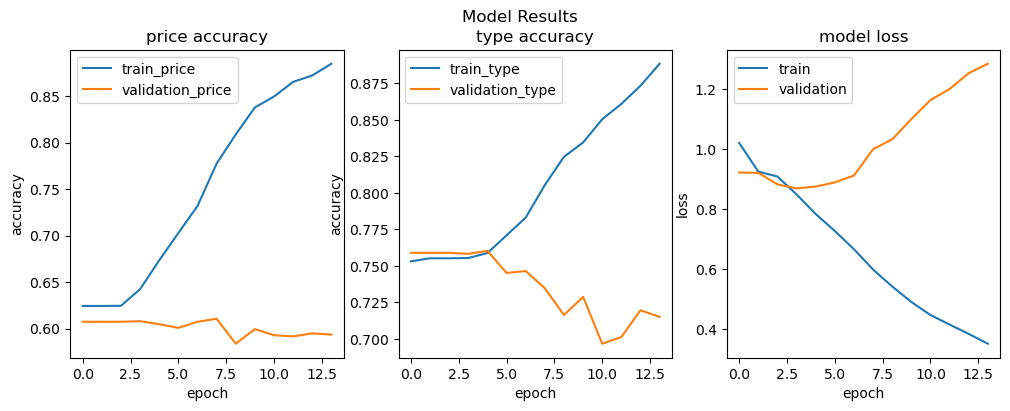

In [24]:
# Looking at the results, we can see that the training accuracy improves and the loss curve is smoother prior to overfitting around epoch 8
results_viz(history)

In [25]:
# Generating predictions using the GRU model
test(gru_model,'trial2')

230/230 [==============================] - 10s 42ms/step


In [26]:
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2)) # input shape for batches of images (size 64x64x2)

# text part
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text) # get our word embeddings
# averaged = tf.reduce_mean(embedded, axis=1) # compute the mean of the embeddings to reduce the rank of the embedding
lstm = GRU(20)(embedded)

# image part
cov = Conv2D(32, (3, 3))(in_image) # convolutional layer with 32 filters, and a 3x3 mask, no padding
pl = MaxPool2D((3, 3))(cov) # max pooling with a 3x3 mask, reducing the size to 20x20x32
cov2 = Conv2D(32, (2,2))(pl) # convolutional layer with 32 filters, and a 2x2 mask, no padding
pl2 = MaxPool2D((2,2))(cov2) # max pooling with a 2x2 mask, reducing the size to 9x9x32
flattened = Flatten()(pl2) # flatten the shape to (2592,)


# fusion:
fused = tf.concat([lstm, flattened], axis=-1) # concatenate text features with image features

# multi-objectives (each is a multi-class classification)
p_price = Dense(len_price, activation='softmax', name='price')(fused) # predict price label 0, 1, or 2
p_type = Dense(len_type, activation='softmax', name='type')(fused) # predict rental category label [0-23]

# model definition
cnn_model = keras.Model(
    inputs={
        'summary': in_text, # text inputs
        'image': in_image # image inputs
    },
    outputs={
        'price': p_price, # label 1: price category (0, 1, or 2)
        'type': p_type, # label 2: type category [0-23]
    },
)

# compile the model with the updated CNN component and print the summary
compile(cnn_model)
cnn_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 62, 62, 32)   608         ['input_8[0][0]']                
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 20, 20, 32)  0           ['conv2d_3[0][0]']               
                                                                                                  
 input_7 (InputLayer)           [(None, 100)]        0           []                               
                                                                                            

In [27]:
# training on 20 epochs with a batch size of 16, early stopping with a patience of 10
history = train(cnn_model, callbacks)

Epoch 1/20
382/382 [==============================] - 37s 89ms/step - loss: 0.9718 - price_loss: 0.8505 - type_loss: 1.0931 - price_sparse_categorical_accuracy: 0.6207 - type_sparse_categorical_accuracy: 0.7530 - val_loss: 0.9319 - val_price_loss: 0.8492 - val_type_loss: 1.0146 - val_price_sparse_categorical_accuracy: 0.6075 - val_type_sparse_categorical_accuracy: 0.7588
Epoch 2/20
382/382 [==============================] - 34s 90ms/step - loss: 0.9340 - price_loss: 0.8403 - type_loss: 1.0276 - price_sparse_categorical_accuracy: 0.6245 - type_sparse_categorical_accuracy: 0.7551 - val_loss: 0.9276 - val_price_loss: 0.8471 - val_type_loss: 1.0081 - val_price_sparse_categorical_accuracy: 0.6075 - val_type_sparse_categorical_accuracy: 0.7588
Epoch 3/20
382/382 [==============================] - 35s 91ms/step - loss: 0.9289 - price_loss: 0.8383 - type_loss: 1.0196 - price_sparse_categorical_accuracy: 0.6245 - type_sparse_categorical_accuracy: 0.7551 - val_loss: 0.9181 - val_price_loss: 0.84

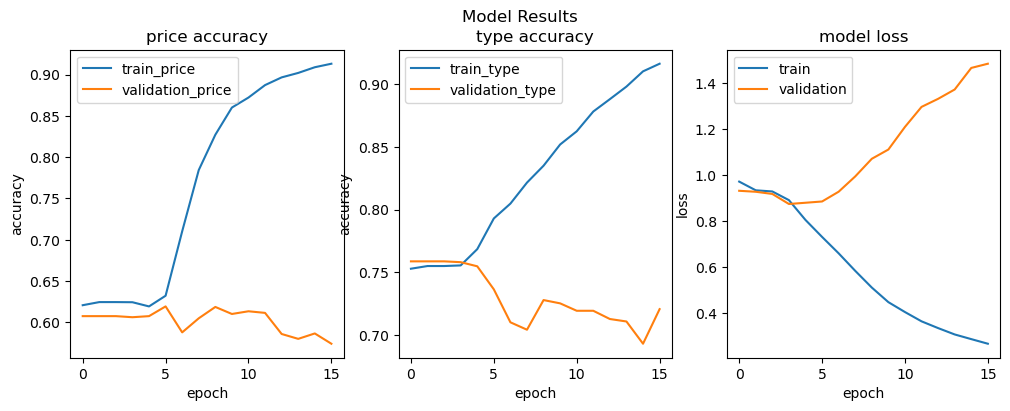

In [28]:
# from these results, it looks like we're starting to overfit
results_viz(history)

In [29]:
# generating predictions
test(cnn_model,'trial3')

230/230 [==============================] - 5s 20ms/step


In [30]:
from tensorflow.keras.layers import Bidirectional # used to implement bidirectional RNNs (LSTM, GRU)

in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2)) # input shape for batches of images (size 64x64x2)

# text part
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text) # get our word embeddings
bi_lstm = Bidirectional(GRU(20))(embedded) # creating a bidirectional GRU layer, with 20 units as before

# image part
cov = Conv2D(32, (3, 3))(in_image) # convolutional layer with 32 filters, and a 16x16 mask, no padding
pl = MaxPool2D((3, 3))(cov) # max pooling with a 3x3 mask, reducing the size to 20x20x32
cov2 = Conv2D(32, (2,2))(pl) # convolutional layer with 32 filters, and a 2x2 mask, no padding
pl2 = MaxPool2D((2,2))(cov2) # max pooling with a 2x2 mask, reducing the size to 9x9x32
flattened = Flatten()(pl2) # flatten the shape to (2592,)


# fusion:
fused = tf.concat([bi_lstm, flattened], axis=-1) # concatenate text features with images

# multi-objectives (each is a multi-class classification)
p_price = Dense(len_price, activation='softmax', name='price')(fused) # predict price label 0, 1, or 2
p_type = Dense(len_type, activation='softmax', name='type')(fused) # predict rental category label [0-23]

# model definition
bi_lstm_model = keras.Model(
    inputs={
        'summary': in_text, # text inputs
        'image': in_image # image inputs
    },
    outputs={
        'price': p_price, # label 1: price category (0, 1, or 2)
        'type': p_type, # label 2: type category [0-23]
    },
)

# compiling the bidirectional model and printing a summary of the architecture
compile(bi_lstm_model)
bi_lstm_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 62, 62, 32)   608         ['input_10[0][0]']               
                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 20, 20, 32)  0           ['conv2d_5[0][0]']               
                                                                                                  
 input_9 (InputLayer)           [(None, 100)]        0           []                               
                                                                                            

In [31]:
# training on 20 epochs, I increased the batch size to 32 to improve training speed
history = train(bi_lstm_model, callbacks, 20, 32)

Epoch 1/20
191/191 [==============================] - 31s 134ms/step - loss: 0.9834 - price_loss: 0.8396 - type_loss: 1.1272 - price_sparse_categorical_accuracy: 0.6250 - type_sparse_categorical_accuracy: 0.7515 - val_loss: 0.8688 - val_price_loss: 0.8155 - val_type_loss: 0.9221 - val_price_sparse_categorical_accuracy: 0.6101 - val_type_sparse_categorical_accuracy: 0.7588
Epoch 2/20
191/191 [==============================] - 24s 126ms/step - loss: 0.8040 - price_loss: 0.7485 - type_loss: 0.8596 - price_sparse_categorical_accuracy: 0.6663 - type_sparse_categorical_accuracy: 0.7645 - val_loss: 0.8198 - val_price_loss: 0.7762 - val_type_loss: 0.8634 - val_price_sparse_categorical_accuracy: 0.6356 - val_type_sparse_categorical_accuracy: 0.7752
Epoch 3/20
191/191 [==============================] - 24s 128ms/step - loss: 0.7202 - price_loss: 0.6807 - type_loss: 0.7597 - price_sparse_categorical_accuracy: 0.7017 - type_sparse_categorical_accuracy: 0.7846 - val_loss: 0.8235 - val_price_loss: 0

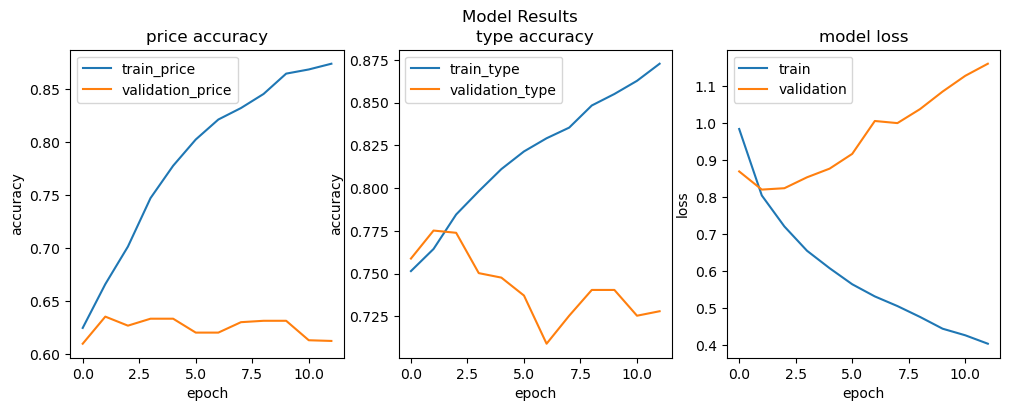

In [32]:
# Still overfitting 😡
results_viz(history)

In [33]:
# generating predictions
test(bi_lstm_model,'trial4')

230/230 [==============================] - 7s 26ms/step


In [34]:
from tensorflow.keras.layers import Dropout

in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2)) # input shape for batches of images (size 64x64x2)

# text part
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text) # get our word embeddings
bi_lstm = Bidirectional(GRU(20, recurrent_regularizer='l2'))(embedded) # adding quadratic regularizer

# image part
cov = Conv2D(32, (3, 3))(in_image) # convolutional layer with 32 filters, and a 16x16 mask, no padding
drop = Dropout(0.2)(cov) # 20% dropout
pl = MaxPool2D((3, 3))(drop) # max pooling with a 3x3 mask, reducing the size to 20x20x32
cov2 = Conv2D(32, (2,2))(pl) # convolutional layer with 32 filters, and a 2x2 mask, no padding
drop2 = Dropout(0.2)(cov2) # 20% dropout
pl2 = MaxPool2D((2,2))(drop2) # max pooling with a 2x2 mask, reducing the size to 9x9x32
flattened = Flatten()(pl2) # flatten the shape to (2592,)


# fusion:
fused = tf.concat([bi_lstm, flattened], axis=-1) # concatenate text features with images

# multi-objectives (each is a multi-class classification)
p_price = Dense(len_price, activation='softmax', name='price')(fused) # predict price label 0, 1, or 2
p_type = Dense(len_type, activation='softmax', name='type')(fused) # predict rental category label [0-23]

# model definition
bi_lstm_model = keras.Model(
    inputs={
        'summary': in_text, # text inputs
        'image': in_image # image inputs
    },
    outputs={
        'price': p_price, # label 1: price category (0, 1, or 2)
        'type': p_type, # label 2: type category [0-23]
    },
)

# compiling the bidirectional model (with regularization) and printing a summary of the architecture
compile(bi_lstm_model)
bi_lstm_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 62, 62, 32)   608         ['input_12[0][0]']               
                                                                                                  
 dropout (Dropout)              (None, 62, 62, 32)   0           ['conv2d_7[0][0]']               
                                                                                                  
 max_pooling2d_7 (MaxPooling2D)  (None, 20, 20, 32)  0           ['dropout[0][0]']                
                                                                                            

In [ ]:
# increasing the batch size to 64 to improve training speed, still 20 epochs
history = train(bi_lstm_model, callbacks, 20, 64) # using a batch size of 64 to speed up training

Epoch 1/20
 4/96 [>.............................] - ETA: 20s - loss: 2.5110 - price_loss: 1.0927 - type_loss: 3.1440 - price_sparse_categorical_accuracy: 0.4297 - type_sparse_categorical_accuracy: 0.5234 

In [ ]:
# still overfitting, but the curves are much smoother, as expected
results_viz(history)

In [ ]:
# generating predictions
test(bi_lstm_model,'trial5')

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPool1D # used to explore convolution on the text part of the model
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2)) # input shape for batches of images (size 64x64x2)

# text part
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text) # get our word embeddings, 40000x100
conv1 = Conv1D(filters=32, kernel_size=5, strides=1, activation='relu')(embedded)
pool = MaxPool1D(pool_size=5)(conv1)
bi_lstm = Bidirectional(GRU(20, recurrent_regularizer='l2'))(pool)

# image part
cov = Conv2D(64, (3, 3))(in_image) # convolutional layer with 32 filters, and a 16x16 mask, no padding
drop = Dropout(0.2)(cov) # 20% dropout, tried vals of: 0, 0.2, 0.3, 0.5
pl = MaxPool2D((3, 3))(drop) # max pooling with a 3x3 mask, reducing the size to 20x20x32
cov2 = Conv2D(32, (2,2))(pl) # convolutional layer with 32 filters, and a 2x2 mask, no padding
drop2 = Dropout(0.2)(cov2) # 20% dropout, tried vals of: 0, 0.2, 0.3, 0.5
pl2 = MaxPool2D((2,2))(drop2) # max pooling with a 2x2 mask, reducing the size to 9x9x32
flattened = Flatten()(pl2) # flatten the shape to (2592,)


# fusion:
fused = tf.concat([bi_lstm, flattened], axis=-1) # concatenate text features with images

# multi-objectives (each is a multi-class classification)
p_price = Dense(len_price, activation='softmax', name='price')(fused) # predict price label 0, 1, or 2
p_type = Dense(len_type, activation='softmax', name='type')(fused) # predict rental category label [0-23]

# model definition
bi_lstm_model = keras.Model(
    inputs={
        'summary': in_text, # text inputs
        'image': in_image # image inputs
    },
    outputs={
        'price': p_price, # label 1: price category (0, 1, or 2)
        'type': p_type, # label 2: type category [0-23]
    },
)

# compiling the bidirectional model (with regularization) and printing a summary of the architecture
compile(bi_lstm_model)
bi_lstm_model.summary()

In [ ]:
# I tried batch sizes of 16, 32, and 64. This configuration worked the best.
history = train(bi_lstm_model, callbacks, 20, 32)

In [ ]:
# noisy validation curves again. What gives?
results_viz(history)

In [ ]:
# nonetheless, let's generate our predictions
test(bi_lstm_model,'trial6')

In [ ]:
from tensorflow.keras.layers import MultiHeadAttention

in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2)) # input shape for batches of images (size 64x64x2)

# text part
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text) # get our word embeddings
# adopted the following to create an attention mechanism: https://discuss.pytorch.org/t/trying-to-understand-nn-multiheadattention-coming-from-keras/122923
attention = MultiHeadAttention(num_heads=2, key_dim=2)(embedded, embedded)
bi_lstm = Bidirectional(GRU(20, recurrent_regularizer='l2'))(attention)


# image part
cov = Conv2D(64, (3, 3))(in_image) # convolutional layer with 32 filters, and a 16x16 mask, no padding
drop = Dropout(0.2)(cov) # 20% dropout, tried vals of: 0, 0.2, 0.3, 0.5
pl = MaxPool2D((3, 3))(drop) # max pooling with a 3x3 mask, reducing the size to 20x20x32
cov2 = Conv2D(32, (2,2))(pl) # convolutional layer with 32 filters, and a 2x2 mask, no padding
drop2 = Dropout(0.2)(cov2) # 20% dropout, tried vals of: 0, 0.2, 0.3, 0.5
pl2 = MaxPool2D((2,2))(drop2) # max pooling with a 2x2 mask, reducing the size to 9x9x32
flattened = Flatten()(pl2) # flatten the shape to (2592,)


# fusion:
fused = tf.concat([bi_lstm, flattened], axis=-1) # concatenate text features with images

# multi-objectives (each is a multi-class classification)
p_price = Dense(len_price, activation='softmax', name='price')(fused) # predict price label 0, 1, or 2
p_type = Dense(len_type, activation='softmax', name='type')(fused) # predict rental category label [0-23]

# model definition
attn_model = keras.Model(
    inputs={
        'summary': in_text, # text inputs
        'image': in_image # image inputs
    },
    outputs={
        'price': p_price, # label 1: price category (0, 1, or 2)
        'type': p_type, # label 2: type category [0-23]
    },
)

# compiling the bidirectional model (with regularization and attention) 
# and printing a summary of the architecture
compile(attn_model)
attn_model.summary()

In [ ]:
history = train(attn_model, callbacks, 20, 32)

In [ ]:
results_viz(history)

In [ ]:
test(attn_model,'trial7')

In [ ]:
# installing txtai
!pip install git+https://github.com/neuml/txtai#egg=txtai[pipeline]

In [ ]:
from txtai.pipeline import Translation
trns = Translation() # instantiating a translation pipeline

In [ ]:
x_tr_text.head() # here we can see that there are both English and French instances

In [ ]:
x_vl_text.head() # here we can see that there are both English and French instances, too

In [ ]:
trns("Logement complet meublé. Cuisine équipée Wi-Fi", "en") # this module translates nicely! 👍

In [ ]:
# The next three cells pre-process our training, validation, and test data,
# which takes a LONG time

# x_text[:1000].apply(lambda x: trns(str(x), "en")) # takes ~7mins, ~6s/10 records
x_tr_text_en = x_tr_text.apply(lambda x: trns(str(x), "en")) # This takes ~40mins

In [ ]:
x_vl_text_en = x_vl_text.apply(lambda x: trns(str(x), "en")) # This takes ~10mins

In [ ]:
x_test_summary = x_test_df.summary.astype(str)
x_test_summary = x_test_summary.apply(lambda x: trns(str(x), "en")) # This takes ~50mins

In [ ]:
x_test_summary = _preprocess(x_test_summary) # create our sequences for the test data

In [ ]:
# re-using the following from the template
vocab_size = 40000 # enforce a threshold on the number of unique words that are tokenized
max_len = 100 # maximum sequence length of a text string, anything longer will be truncated to 100 words

# build vocabulary from training set
tokenizer = Tokenizer(num_words=vocab_size) # initialize tokenizer with a vocabulary size of 40000
tokenizer.fit_on_texts(x_tr_text_en) # update the vocabulary by fitting on the corpus of text contained in rental text descriptions, keeping only the most common 40000 words

x_tr_text_id = _preprocess(x_tr_text_en) # preprocess and tokenize list of training sequences
x_vl_text_id = _preprocess(x_vl_text_en) # preprocess and tokenize list of validation sequences


In [ ]:
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2)) # input shape for batches of images (size 64x64x2)

# text part
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text) # get our word embeddings
attention = MultiHeadAttention(num_heads=2, key_dim=2)(embedded, embedded) # multi-head attention with 2 heads
bi_lstm = Bidirectional(GRU(20, recurrent_regularizer='l2'))(attention)


# image part
cov = Conv2D(64, (3, 3))(in_image) # convolutional layer with 32 filters, and a 16x16 mask, no padding
drop = Dropout(0.2)(cov) # 20% dropout, tried vals of: 0, 0.2, 0.3, 0.5
pl = MaxPool2D((3, 3))(drop) # max pooling with a 3x3 mask, reducing the size to 20x20x32
cov2 = Conv2D(32, (2,2))(pl) # convolutional layer with 32 filters, and a 2x2 mask, no padding
drop2 = Dropout(0.2)(cov2) # 20% dropout, tried vals of: 0, 0.2, 0.3, 0.5
pl2 = MaxPool2D((2,2))(drop2) # max pooling with a 2x2 mask, reducing the size to 9x9x32
flattened = Flatten()(pl2) # flatten the shape to (2592,)


# fusion:
fused = tf.concat([bi_lstm, flattened], axis=-1) # concatenate text features with images

# multi-objectives (each is a multi-class classification)
p_price = Dense(len_price, activation='softmax', name='price')(fused) # predict price label 0, 1, or 2
p_type = Dense(len_type, activation='softmax', name='type')(fused) # predict rental category label [0-23]

# model definition
attn_model = keras.Model(
    inputs={
        'summary': in_text, # text inputs
        'image': in_image # image inputs
    },
    outputs={
        'price': p_price, # label 1: price category (0, 1, or 2)
        'type': p_type, # label 2: type category [0-23]
    },
)

# compiling the bidirectional model (with regularization and attention) 
# and printing a summary of the architecture
compile(attn_model)
attn_model.summary()

In [ ]:
# training the model with attention using stock hyperparameters
history = train(attn_model, callbacks, 20, 16)

In [ ]:
# still noisy 😡
results_viz(history)

In [ ]:
# generating predictions
test(attn_model,'trial8')

In [ ]:
from keras.applications.vgg16 import VGG16

# VGG needs input images with 3 channels, so I'll extend the training data to have 3 channels and appear RGB
# x_tr_image is currently (6101, 64, 64, 2)
rgb_tr = x_tr_image[:,:,:,0]
rgb_vl = x_vl_image[:,:,:,0]
# rgb.shape # now it's (6101, 64, 64)
plt.imshow(rgb_tr[0, :, :]) # looks the same as it did before
rgb_tr = np.repeat(rgb_tr[..., np.newaxis], 3, -1) # repeat the same values across 3 channels
rgb_vl = np.repeat(rgb_vl[..., np.newaxis], 3, -1) # repeat the same values across 3 channels
print(rgb_tr.shape) # now we have 487 samples of (6101, 64, 64, 3)
print(rgb_vl.shape) # now we have 487 samples of (1526, 64, 64, 3)

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Rescaling

# bringing VGG16 into the mix
base = VGG16(include_top=False, input_shape=(64,64,3)) # instantiating the base model we wish to tune
base.trainable = False # freezing the weights

In [ ]:
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 3)) # input shape for batches of images (size 64x64x2)

# text part
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text) # get our word embeddings
# averaged = tf.reduce_mean(embedded, axis=1) # compute the mean of the embeddings to reduce the rank of the embedding
attention = MultiHeadAttention(num_heads=2, key_dim=2)(embedded, embedded)
bi_lstm = Bidirectional(GRU(50, recurrent_regularizer='l2'))(attention)


# image part
scaling = Rescaling(1./127.5, offset=-1)(in_image) # rescaling to [-1,1] for VGG16
vgg = base(scaling, training=False) # pass the base model the scaled inputs
pl = GlobalAveragePooling2D()(vgg) # global average pooling, pretty much the same as flattening
do = Dropout(0.2)(pl) # dropout at a rate of 20%
fl = Flatten()(do) # flattening anyways


# fusion:
fused = tf.concat([bi_lstm, fl], axis=-1) # concatenate text features with images

# multi-objectives (each is a multi-class classification)
p_price = Dense(len_price, activation='softmax', name='price')(fused) # predict price label 0, 1, or 2
p_type = Dense(len_type, activation='softmax', name='type')(fused) # predict rental category label [0-23]

# model definition
attn_model = keras.Model(
    inputs={
        'summary': in_text, # text inputs
        'image': in_image # image inputs
    },
    outputs={
        'price': p_price, # label 1: price category (0, 1, or 2)
        'type': p_type, # label 2: type category [0-23]
    },
)

# compiling the updated attention model and printing the summary
compile(attn_model)
attn_model.summary()

In [ ]:
# history = train(lstm_model, callbacks)
history = attn_model.fit(
      # our inputs: tokenized text sequences and resized image samples
      x={
          'summary': x_tr_text_id,
          'image': rgb_tr # can't use my helper function as I have a different image input
      },
      # our outputs: price and rental type categories
      y={
          'price': y_tr_price,
          'type': y_tr_type,
      },
      epochs=20, # train for 20 epochs (iterations over all training data)
      batch_size=32, # batch size of 16 (samples processed before updating gradients)
      # our validation splits for our two input sets and our two target attributes
      validation_data=(
          {
              'summary': x_vl_text_id,
              'image': rgb_vl # can't use my helper function as I have a different validation set
          }, 
          {
              'price': y_vl_price,
              'type': y_vl_type,
          }),
      # validation_split=0.2, # validate on a hold-out set of 20%, even though splits were already created above???? This is redundant.
      # use early stopping, monitor the validation price loss and if it does not improve for 5 consecutive epochs, training will stop
      callbacks=[
          tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5, ) # setting patience back to 5
      ],
      verbose=1 # one line per epoch displaying performance metrics
  )

In [ ]:
# this looks a lot better! Typical training/validation loss curve where we can see overfitting start to occur after just a few epochs
results_viz(history)

In [ ]:
# preprocess the test images the same way as our training and validation sets
rgb_test = x_test_image[:,:,:,0]
plt.imshow(rgb_test[0, :, :]) # looks the same as it did before
rgb_test = np.repeat(rgb_test[..., np.newaxis], 3, -1) # repeat the same values across 3 channels
print(rgb_test.shape) # now we have 487 samples of (7360,256,256,3)

In [ ]:
# test(attn_model,'trial9')
# can't use my test helper for this trial either, using the below from the template
y_predict = attn_model.predict(
    {
        'summary': x_test_summary,
        'image': rgb_test
    }
)
price_predicted = y_predict['price'] 
price_category_predicted = np.argmax(price_predicted, axis=1) 

# create the submission dataframe/csv for submission
pd.DataFrame(
    {'id': x_test_df.id,
    'price': price_category_predicted}).to_csv('trial9.csv', index=False)


In [ ]:
import tensorflow_hub as hub
encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1'
preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
bert_preprocess_model = hub.KerasLayer(preprocess)

In [ ]:
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 3)) # input shape for batches of images (size 64x64x2)

# text part
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text) # get our word embeddings
# averaged = tf.reduce_mean(embedded, axis=1) # compute the mean of the embeddings to reduce the rank of the embedding
attention = MultiHeadAttention(num_heads=5, key_dim=2)(embedded, embedded)
bi_lstm = Bidirectional(GRU(30))(attention)


# image part
scaling = Rescaling(1./127.5, offset=-1)(in_image) # rescaling to [-1,1] for VGG16
vgg = base(scaling, training=False) # pass the base model the scaled inputs
# do = Dropout(0.2)(vgg) # tried dropout, but it didn't result in improvement
pl = GlobalAveragePooling2D()(vgg) # global average pooling, pretty much the same as flattening

# removed the layers below, had a negligible impact on performance
# do = Dropout(0.2)(pl) # dropout at a rate of 20%
# fl = Flatten()(do) # flattening anyways


# fusion:
fused = tf.concat([bi_lstm, pl], axis=-1) # concatenate text features with images

# multi-objectives (each is a multi-class classification)
p_price = Dense(len_price, activation='softmax', name='price')(fused) # predict price label 0, 1, or 2
p_type = Dense(len_type, activation='softmax', name='type')(fused) # predict rental category label [0-23]

# model definition
attn_model = keras.Model(
    inputs={
        'summary': in_text, # text inputs
        'image': in_image # image inputs
    },
    outputs={
        'price': p_price, # label 1: price category (0, 1, or 2)
        'type': p_type, # label 2: type category [0-23]
    },
)

# compiling the updated attention model and printing the summary
compile(attn_model)
attn_model.summary()

In [ ]:
# history = train(lstm_model, callbacks)
history = attn_model.fit(
      # our inputs: tokenized text sequences and resized image samples
      x={
          'summary': x_tr_text_id,
          'image': rgb_tr # can't use my helper function as I have a different image input
      },
      # our outputs: price and rental type categories
      y={
          'price': y_tr_price,
          'type': y_tr_type,
      },
      epochs=20, # train for 20 epochs (iterations over all training data)
      batch_size=32, # batch size of 16 (samples processed before updating gradients)
      # our validation splits for our two input sets and our two target attributes
      validation_data=(
          {
              'summary': x_vl_text_id,
              'image': rgb_vl # can't use my helper function as I have a different validation set
          }, 
          {
              'price': y_vl_price,
              'type': y_vl_type,
          }),
      # validation_split=0.2, # validate on a hold-out set of 20%, even though splits were already created above???? This is redundant.
      # use early stopping, monitor the validation price loss and if it does not improve for 5 consecutive epochs, training will stop
      callbacks=[
          tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=10, ) # setting patience back to 5
      ],
      verbose=1 # one line per epoch displaying performance metrics
  )

In [ ]:
results_viz(history)

In [ ]:
# test(attn_model,'trial9')
# can't use my test helper for this trial either, using the below from the template
y_predict = attn_model.predict(
    {
        'summary': x_test_summary,
        'image': rgb_test
    }
)
price_predicted = y_predict['price'] 
price_category_predicted = np.argmax(price_predicted, axis=1) 

# create the submission dataframe/csv for submission
pd.DataFrame(
    {'id': x_test_df.id,
    'price': price_category_predicted}).to_csv('trial10.csv', index=False)


🌈Is fully-connected model a good one for sequential data? Why? How about for image data? Is it good? Why?

A fully connected neural network consists of a series of fully connected layers that connect every neuron in one layer to every neuron in the other layer. The major advantage of fully connected networks is that they can be used for any type of data, including sequential data and image data. However, fully connected networks are not ideal for image data because they have too many parameters and are prone to overfitting. Convolutional neural networks (CNNs) are better suited for image data because they use convolutional layers that can learn spatial hierarchies of features from images. CNNs have fewer parameters than fully connected networks and are less prone to overfitting

🌈What is gradient vanishing and gradient explosion, and how GRU/LSTM tries to mitigate this problem?

Gradient vanishing and gradient explosion are two problems that can occur when training deep neural networks. Gradient vanishing occurs when the gradients become too small and cause the weights to stop updating during training. Gradient explosion occurs when the gradients become too large and cause the weights to update too much during training.

Gated Recurrent Units (GRUs) and Long Short-Term Memory (LSTM) units are two types of recurrent neural networks (RNNs) that can mitigate these problems. LSTMs solve the problem of vanishing gradients using a unique additive gradient structure that includes direct access to the forget gate’s activations, enabling the network to encourage desired behavior from the error gradient using frequent gates update on every time step of the learning process. GRUs are simple, fast and solve vanishing gradient problem easily

🌈What is multi-objective/multi-task learning? What is multi-modality learning? How do you use them in this assignment?

Multi-objective learning (MOL) or multi-task learning (MTL) is a machine learning technique that involves training a single model to perform multiple tasks simultaneously. Multi-modality learning is a machine learning technique that involves training a single model on data from multiple modalities.

In this assignment, we are using multi-task learning to train a single model to perform two tasks simultaneously: predicting the toxicity score and predicting the identity of the chemical compound. We are not using multi-modality learning in this assignment because we are only using one type of data (text) to train our model.

🌈What is the difference among xgboost, lightgbm and catboost

XGBoost, LightGBM and CatBoost are all gradient boosting frameworks that can be used for supervised learning tasks such as classification and regression.

XGBoost stands for eXtreme Gradient Boosting and is a popular gradient boosting framework that uses a gradient descent algorithm to minimize loss. LightGBM stands for Light Gradient Boosting Machine and is another popular gradient boosting framework that uses a histogram-based algorithm to speed up training. CatBoost stands for Categorical Boosting and is a gradient boosting framework that can handle categorical features well.

The main difference between these three frameworks is in how they handle tree construction. XGBoost and LightGBM use asymmetric trees, meaning splitting conditions for each node across the same depth can differ. CatBoost builds symmetric (balanced) trees, meaning splitting conditions are consistent across all nodes at the same depth of the tree